<div style="text-align:center">
    <h1>Supernova plot developement</h1>
</div>

In [1]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd

In [58]:
from importlib import reload
import sys
sys.path.append("../src")
import plotting

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("default")


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [37]:
p = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/supernovae/TESTING")

In [143]:
(p.initC["kstar_2"] == 15).sum()

5021

In [147]:
len(p.bpp["bin_num"][(p.bpp.groupby("bin_num")["mass_1"].diff().fillna(0.0) > 0.0) | (p.bpp.groupby("bin_num")["mass_2"].diff().fillna(0.0) > 0.0)].unique())

4934

In [236]:
rlof_nums = p.bpp[(p.bpp["evol_type"] >= 3) & (p.bpp["evol_type"] <= 8)]["bin_num"].unique()
interaction_nums = np.concatenate((rlof_nums, p.bpp["bin_num"][(p.bpp.groupby("bin_num")["mass_1"].diff().fillna(0.0) > 0.0)
                                              | (p.bpp.groupby("bin_num")["mass_2"].diff().fillna(0.0) > 0.0)].unique()))
1 - (len(interaction_nums) / len(p.bin_nums))

0.0917

In [61]:
def find_duplicate_supernovae(p):
    uni, counts = np.unique(p.bpp[p.bpp["evol_type"] == 15]["bin_num"], return_counts=True)
    duplicate_SN1 = uni[counts > 1]
    uni, counts = np.unique(p.bpp[p.bpp["evol_type"] == 16]["bin_num"], return_counts=True)
    duplicate_SN2 = uni[counts > 1]
    p.duplicate_sn = np.concatenate((duplicate_SN1, duplicate_SN2))
    return p.duplicate_sn

def subpop_masks(p):
    if not hasattr(p, "duplicate_sn"):
        find_duplicate_supernovae(p)
    sn_rows = p.bpp[((p.bpp["evol_type"] == 15) | (p.bpp["evol_type"] == 16)) & ~p.bpp["bin_num"].isin(p.duplicate_sn)]
    sn_initC = p.initC.loc[sn_rows["bin_num"]]
    single_bin_nums = sn_initC[sn_initC["kstar_2"] == 15].index.values
    
    primary_sn_rows = sn_rows[sn_rows["evol_type"] == 15]
    secondary_sn_rows = sn_rows[sn_rows["evol_type"] == 16]

    p.sn_singles = primary_sn_rows["bin_num"].isin(single_bin_nums)
    
    sn_1_sep_zero = primary_sn_rows["bin_num"].isin(primary_sn_rows["bin_num"][primary_sn_rows["sep"] == 0.0])
    p.sn_1_merger = ~p.sn_singles & sn_1_sep_zero
    p.sn_1 = ~p.sn_singles & ~sn_1_sep_zero
    
    sn_2_sep_zero = secondary_sn_rows["bin_num"].isin(secondary_sn_rows["bin_num"][secondary_sn_rows["sep"] == 0.0])
    p.sn_2_merger = sn_2_sep_zero
    p.sn_2 = ~sn_2_sep_zero
    
    print(p.sn_singles.sum(), p.sn_1.sum(), p.sn_2.sum(), p.sn_1_merger.sum() + p.sn_2_merger.sum())
    
    return p.sn_singles, p.sn_1, p.sn_1_merger, p.sn_2, p.sn_2_merger

def set_sn_subpop_masks(p):
    if not hasattr(p, "duplicate_sn"):
        find_duplicate_supernovae(p)
        
    sn_rows = p.bpp[((p.bpp["evol_type"] == 15) | (p.bpp["evol_type"] == 16)) & ~p.bpp["bin_num"].isin(p.duplicate_sn)]
    # sn_initC = p.initC.loc[sn_rows["bin_num"]]
    # single_bin_nums = sn_initC[sn_initC["kstar_2"] == 15].index.values
    
    primary_sn_rows = sn_rows[sn_rows["evol_type"] == 15]
    secondary_sn_rows = sn_rows[sn_rows["evol_type"] == 16]

    interaction_nums = p.bpp[(p.bpp["evol_type"] >= 3) & (p.bpp["evol_type"] <= 8)]["bin_num"].unique()
    p.sn_1_singles = ~primary_sn_rows["bin_num"].isin(interaction_nums)
    p.sn_2_singles = ~secondary_sn_rows["bin_num"].isin(interaction_nums)
    
    sn_1_sep_zero = primary_sn_rows["bin_num"].isin(primary_sn_rows["bin_num"][primary_sn_rows["sep"] == 0.0])
    p.sn_1_merger = ~p.sn_1_singles & sn_1_sep_zero
    p.sn_1 = ~p.sn_1_singles & ~sn_1_sep_zero
    
    sn_2_sep_zero = secondary_sn_rows["bin_num"].isin(secondary_sn_rows["bin_num"][secondary_sn_rows["sep"] == 0.0])
    p.sn_2_merger = ~p.sn_2_singles & sn_2_sep_zero
    p.sn_2 = ~p.sn_2_singles & ~sn_2_sep_zero
    
    print(p.sn_1_singles.sum() + p.sn_2_singles.sum(), p.sn_1.sum(), p.sn_2.sum(), p.sn_1_merger.sum() + p.sn_2_merger.sum())
    
    return p.sn_1_singles, p.sn_2_singles, p.sn_1, p.sn_1_merger, p.sn_2, p.sn_2_merger

In [62]:
set_sn_subpop_masks(p)

2655 783 608 1431


(1396580    False
 1019251     True
 1339511    False
 614321     False
 1312406    False
            ...  
 622446      True
 117029     False
 39153      False
 2144140    False
 394552      True
 Name: bin_num, Length: 3631, dtype: bool,
 1396580    False
 1339511    False
 651325      True
 921734      True
 34199      False
            ...  
 368962     False
 382694     False
 41417      False
 39153      False
 2137485    False
 Name: bin_num, Length: 1846, dtype: bool,
 1396580     True
 1019251    False
 1339511     True
 614321      True
 1312406    False
            ...  
 622446     False
 117029     False
 39153       True
 2144140     True
 394552     False
 Name: bin_num, Length: 3631, dtype: bool,
 1396580    False
 1019251    False
 1339511    False
 614321     False
 1312406     True
            ...  
 622446     False
 117029      True
 39153      False
 2144140    False
 394552     False
 Name: bin_num, Length: 3631, dtype: bool,
 1396580     True
 1339511     True


In [43]:
f = np.load(f"/mnt/home/twagg/ceph/pops/supernovae/sn_positions-TESTING.npz")
p.primary_sn_distances, p.secondary_sn_distances = f["arr_0"] * u.kpc, f["arr_1"] * u.kpc

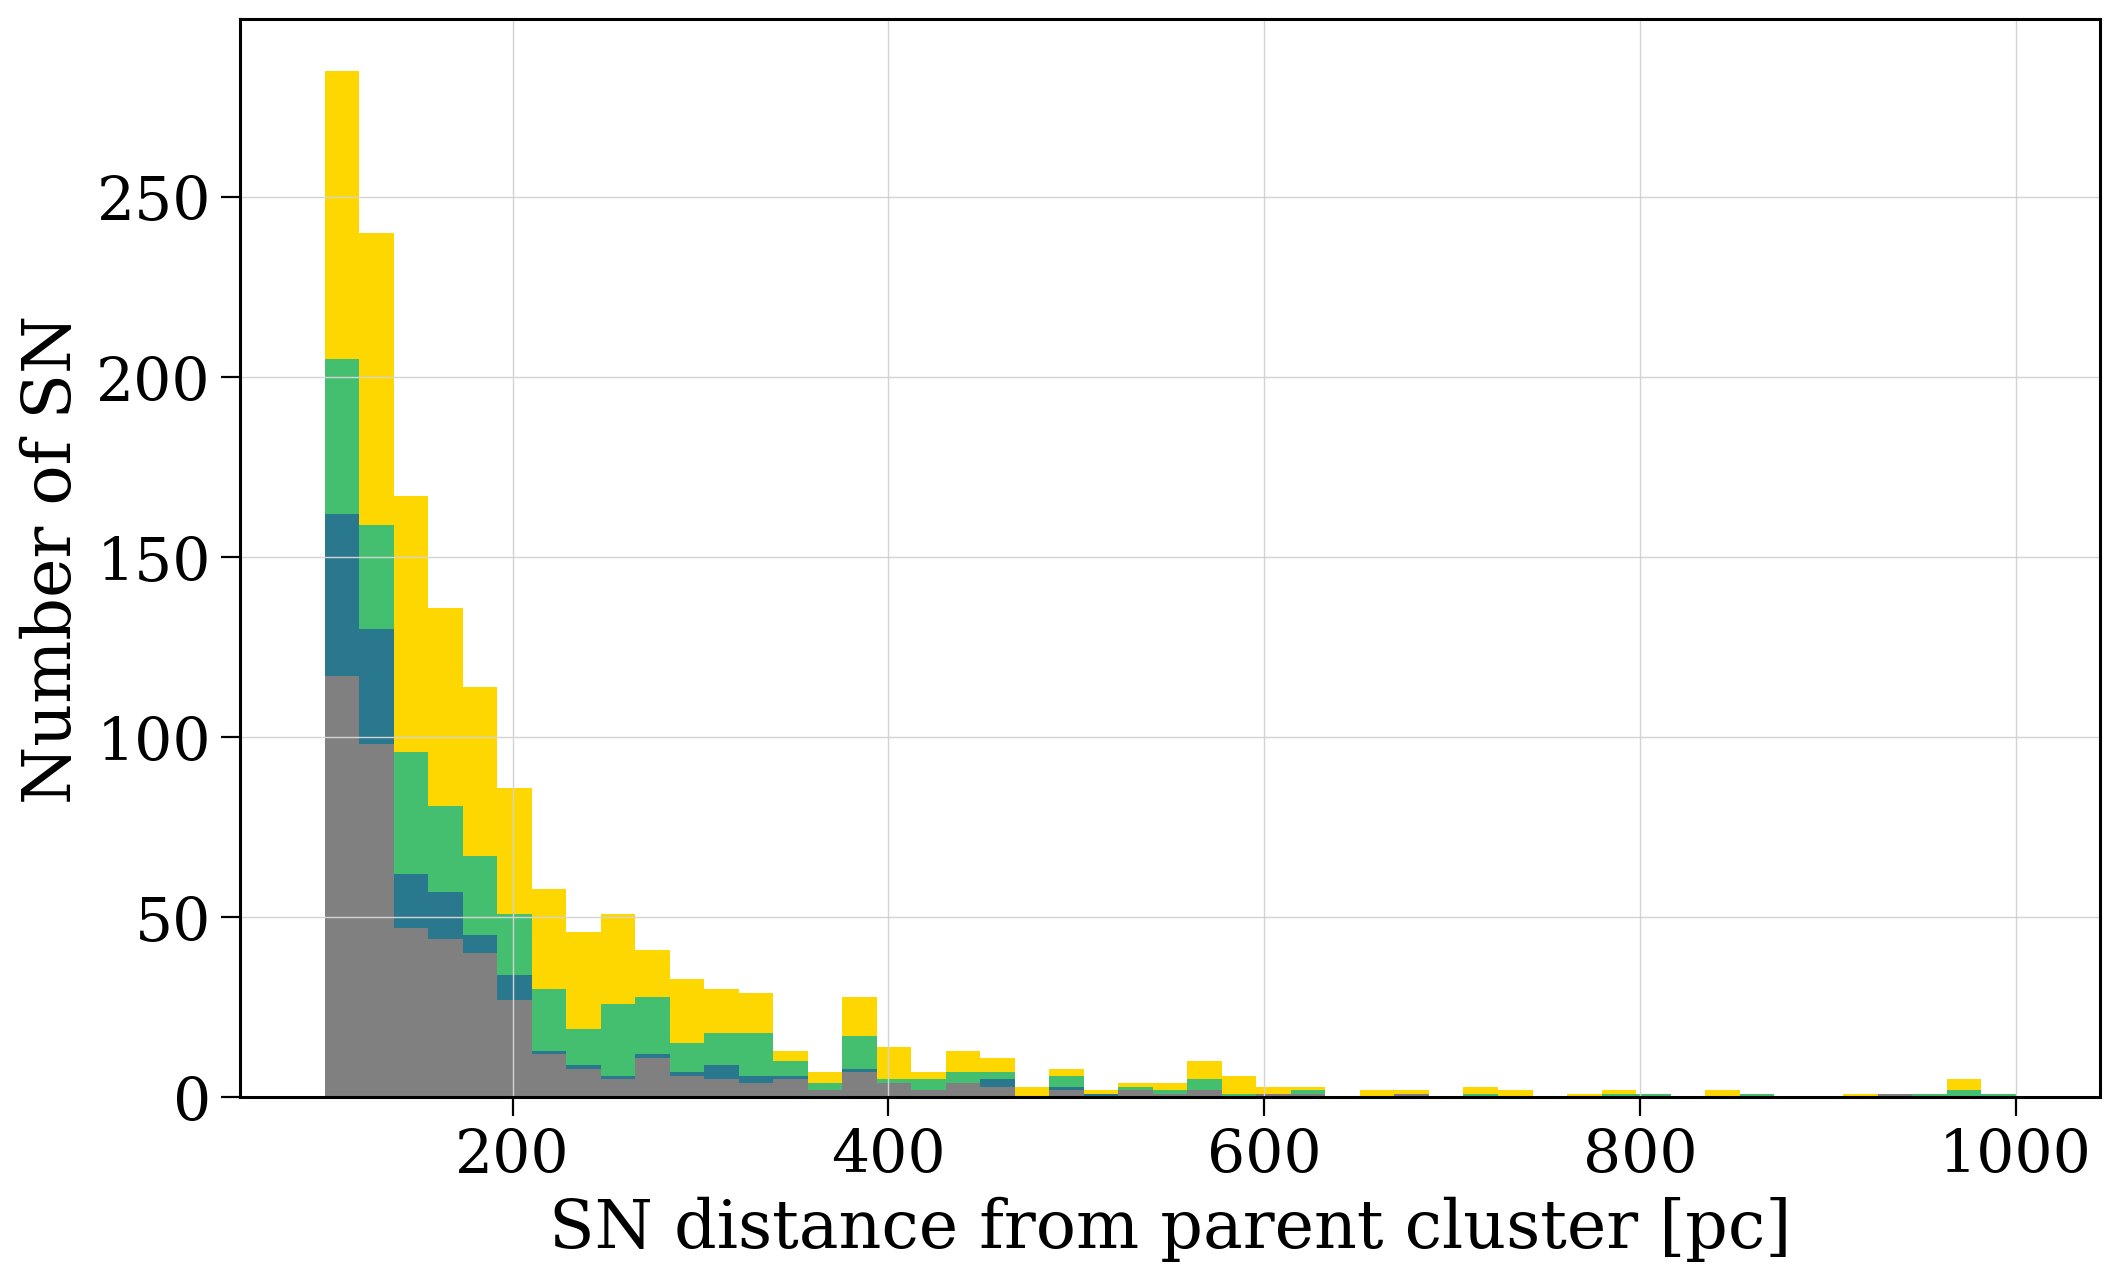

In [71]:
fig, ax = plt.subplots(figsize=(12, 7))

bins = np.linspace(100, 1000, 50)

bin_centres = np.array([(bins[i] + bins[i + 1]) / 2. for i in range(len(bins) - 1)])
widths = np.insert(bin_centres[1:] - bin_centres[:-1], -1, bin_centres[1] - bin_centres[0])

ax.hist([np.concatenate((p.primary_sn_distances.to(u.pc).value[p.sn_1_singles], p.secondary_sn_distances.to(u.pc).value[p.sn_2_singles])),
         p.primary_sn_distances.to(u.pc).value[p.sn_1],
         p.secondary_sn_distances.to(u.pc).value[p.sn_2],
         np.concatenate((p.primary_sn_distances.to(u.pc).value[p.sn_1_merger], p.secondary_sn_distances.to(u.pc).value[p.sn_2_merger]))],
        bins=bins, label=["Effectively Single", "Primary", "Secondary", "Merger Product"], stacked=True,
        color=["grey", plt.cm.viridis(0.4), plt.cm.viridis(0.7), "gold"]);
ax.set_ylabel(ylabel="Number of SN")

ax.set(xlabel="SN distance from parent cluster [pc]")
ax.grid(linewidth=0.5, color="lightgrey")

In [149]:
plotting.set_sn_subpop_masks(p)

85 1146 757 1431


(1396580    False
 1019251    False
 1339511    False
 614321     False
 1312406    False
            ...  
 622446     False
 117029     False
 39153      False
 2144140    False
 394552     False
 Name: bin_num, Length: 3631, dtype: bool,
 1396580    False
 1339511    False
 651325     False
 921734     False
 34199      False
            ...  
 368962     False
 382694     False
 41417      False
 39153      False
 2137485    False
 Name: bin_num, Length: 1846, dtype: bool,
 1396580     True
 1019251    False
 1339511     True
 614321      True
 1312406    False
            ...  
 622446     False
 117029     False
 39153       True
 2144140     True
 394552     False
 Name: bin_num, Length: 3631, dtype: bool,
 1396580    False
 1019251    False
 1339511    False
 614321     False
 1312406     True
            ...  
 622446     False
 117029      True
 39153      False
 2144140    False
 394552     False
 Name: bin_num, Length: 3631, dtype: bool,
 1396580     True
 1339511     True


In [211]:
p.bpp[p.bpp["evol_type"] == 15]

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num
1396580,15.800846,2.912632,19.637876,8.0,1.0,1330.310747,1184.196149,0.0,0.001421,1.152485e-02,15.0,2.445129,4.394732,2.262641,8.605983e+00,1.976909,0.0,16.543826,8.434885e+00,3.012046,19.637876,48954.746547,6.052762e+04,21203.147561,3.131255e+04,0.000070,0.000000e+00,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,7.595746e+06,3150.750958,0.0,0.0,0.0,0.0,0.0,0.0,13.355359,11.405757,0.0,0.0,1396580
1019251,19.677190,10.291879,0.000000,5.0,15.0,0.000000,0.000000,-1.0,0.000100,1.000000e-20,15.0,20.508462,0.000000,18.296813,1.000000e+10,3.482994,0.0,1231.841846,1.000000e-10,11.543086,0.000000,103951.545378,1.000000e-10,2966.196184,1.833452e+06,6.069550,1.000000e-10,4.995404e+00,1.000000e-10,1.134239e+03,1.000000e-10,2.087605e+14,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.831857,0.000000,0.0,0.0,1019251
1339511,5.068271,7.745896,37.445408,8.0,1.0,2089.593267,1646.786750,0.0,0.001541,1.064938e-02,15.0,0.787536,1.516750,0.753457,4.791170e+00,5.882331,0.0,1.061389,1.140772e+01,8.077003,37.445408,227401.843771,2.464398e+05,122894.046764,3.824704e+04,0.000070,0.000000e+00,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,4.169710e+06,2778.890838,0.0,0.0,0.0,0.0,0.0,0.0,4.280123,3.550896,0.0,0.0,1339511
614321,6.655392,5.659070,24.805979,8.0,1.0,158.793139,42.016398,0.0,0.016241,1.008332e-01,15.0,1.041643,1.496796,0.984306,6.672617e+00,4.214905,0.0,1.605787,8.071812e+00,5.906488,24.805979,149979.943247,8.833766e+04,90039.674876,3.518200e+04,0.000070,0.000000e+00,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,3.327867e+08,3999.578162,0.0,0.0,0.0,0.0,0.0,0.0,5.613682,5.158529,0.0,0.0,614321
1312406,170.868407,1.862213,0.000000,9.0,15.0,0.000000,0.000000,-1.0,0.000100,-1.000000e+00,15.0,5.234108,3.680743,4.745802,8.004261e+00,1.437852,0.0,257.569409,3.240722e-01,1.976938,1.531432,47541.446677,1.400146e+03,5334.461293,6.230058e+04,0.002565,0.000000e+00,4.251129e-01,1.531432e+00,2.575668e+02,3.240722e-01,1.154940e+12,90081.836867,0.0,0.0,0.0,0.0,0.0,0.0,165.633736,163.724352,0.0,0.0,1312406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622446,31.021063,8.625661,0.000000,5.0,15.0,0.000000,0.000000,-1.0,0.000100,1.000000e-20,15.0,31.732903,0.000000,28.241556,1.000000e+10,2.576152,0.0,697.970357,1.000000e-10,9.151418,0.000000,46520.537246,1.000000e-10,3223.014817,1.833452e+06,12.587666,1.000000e-10,4.950875e+00,1.000000e-10,6.518374e+02,1.000000e-10,2.714360e+14,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.712903,0.000000,0.0,0.0,622446
117029,132.466323,2.058367,0.000000,9.0,15.0,0.000000,0.000000,-1.0,0.000100,-1.000000e+00,15.0,4.461952,2.358676,4.074996,6.508679e+00,1.440000,0.0,210.085767,3.362807e-01,2.140656,1.689551,36230.599771,1.766686e+03,5518.743087,6.481992e+04,0.000070,0.000000e+00,6.183782e-01,1.689551e+00,2.100857e+02,3.362807e-01,1.881012e+12,88242.534695,0.0,0.0,0.0,0.0,0.0,0.0,128.004357,126.915239,0.0,0.0,117029
39153,12.761775,3.322604,25.499578,8.0,1.0,485.559821,230.979186,0.0,0.004412,4.926885e-02,15.0,1.988767,4.883514,1.845011,6.458174e+00,2.316712,0.0,10.788682,1.362034e+01,3.454697,25.499578,63309.205031,1.503257e+05,27999.619934,3.093385e+04,0.000070,0.000000e+00,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,2.557044e+10,1492.340390,0.0,0.0,0.0,0.0,0.0,0.0,10.772266,7.877520,0.0,0.0,39153
2144140,23.041125,1.423158,3.863944,9.0,1.0,51.739879,18.758644,0.0,0.065327,1.010580e-01,15.0,4.005152,11.014766,3.693929,2.001267e+02,1.420520,0.0,1.002632,2.442393e+00,2.256814,3.863944,23681.530344,2.059688e+02,71829.229659,1.405440e+04,0.007749,0.000000e+00,1.000000e-10,1.000000e-10,1.000000e-10,1.

In [223]:
p.bpp

,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2,bin_num
1053320,0.000000,5.787440,0.0,1.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,1.0,0.000000,0.0,7.415347e+01,1.000000e+10,0.000000,0.0,2.923996,1.000000e-10,5.787440,0.0,880.791577,1.000000e-10,18471.387969,1.833452e+06,0.000000,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,4327.605715,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1053320
1053320,74.348134,5.769298,0.0,2.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,2.0,74.688610,0.0,7.468860e+01,1.000000e+10,1.023682,0.0,6.812275,1.000000e-10,5.769298,0.0,2572.212630,1.000000e-10,15819.772741,1.833452e+06,0.208287,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,945.029125,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.340475,0.0,0.0,0.0,1053320
1053320,74.624070,5.768850,0.0,3.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,2.0,74.977875,0.0,7.470189e+01,1.000000e+10,1.044130,0.0,68.351296,1.000000e-10,5.768850,0.0,1419.606965,1.000000e-10,4304.654133,1.833452e+06,0.211418,1.000000e-10,2.362464e+00,1.000000e-10,4.429197e+01,1.000000e-10,7.069548,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.353805,0.0,0.0,0.0,1053320
1053320,74.758595,5.767523,0.0,4.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,2.0,75.112401,0.0,7.470189e+01,1.000000e+10,1.045908,0.0,162.744156,1.000000e-10,5.768850,0.0,4966.815195,1.000000e-10,3815.367799,1.833452e+06,0.211689,1.000000e-10,4.721616e+00,1.000000e-10,1.625325e+02,1.000000e-10,1.245512,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.353805,0.0,0.0,0.0,1053320
1053320,84.901417,5.678023,0.0,5.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,2.0,85.255222,0.0,7.470189e+01,1.000000e+10,1.411967,0.0,132.532384,1.000000e-10,5.768850,0.0,3449.114982,1.000000e-10,3859.539803,1.833452e+06,0.263431,1.000000e-10,4.266056e+00,1.000000e-10,1.322690e+02,1.000000e-10,1.820727,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.353805,0.0,0.0,0.0,1053320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311128,177.565027,4.062059,0.0,4.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,2.0,177.699670,0.0,1.761757e+02,1.000000e+10,0.655637,0.0,97.731635,1.000000e-10,4.063551,0.0,1617.429396,1.000000e-10,3719.275605,1.833452e+06,0.144744,1.000000e-10,3.406422e+00,1.000000e-10,9.758689e+01,1.000000e-10,3.015434,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.134642,0.0,0.0,0.0,311128
311128,209.201798,4.013505,0.0,5.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,2.0,209.336440,0.0,1.761757e+02,1.000000e+10,0.897634,0.0,68.993986,1.000000e-10,4.063551,0.0,885.630795,1.000000e-10,3807.826657,1.833452e+06,0.188241,1.000000e-10,3.115872e+00,1.000000e-10,6.880574e+01,1.000000e-10,5.991059,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.134642,0.0,0.0,0.0,311128
311128,210.724089,3.964809,0.0,6.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,2.0,210.858731,0.0,1.761757e+02,1.000000e+10,0.842959,0.0,458.898241,1.000000e-10,4.063551,0.0,14185.397933,1.000000e-10,2953.736810,1.833452e+06,0.049102,1.000000e-10,3.121850e+00,1.000000e-10,4.588491e+02,1.000000e-10,0.121832,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.134642,0.0,0.0,0.0,311128
311128,211.274133,0.857469,0.0,11.0,15.0,0.0,0.0,-1.0,0.0001,1.000000e-20,2.0,0.000000,0.0,1.761757e+02,1.000000e+10,0.857469,0.0,0.009656,1.000000e-10,0.857469,0.0,30.489203,1.000000e-10,138643.801374,1.833452e+06,0.009656,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,0.000006,NaN,0.0,0.0,0.0,0.0,0.0,0.0,211.274133,0.0,0.0,0.0,311128


In [221]:
p.bpp.groupby("bin_num")["mass_1"] - p.bpp.groupby("bin_num")["mass_1"].first()

/mnt/home/twagg/miniconda3/envs/cogsworth/lib/python3.10/site-packages/pandas/core/roperator.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return right - left


ValueError: operands could not be broadcast together with shapes (10000,2) (10000,) 

0.02487562189054726
0.3353819139596137
0.2215393620134621
0.4182031021363769


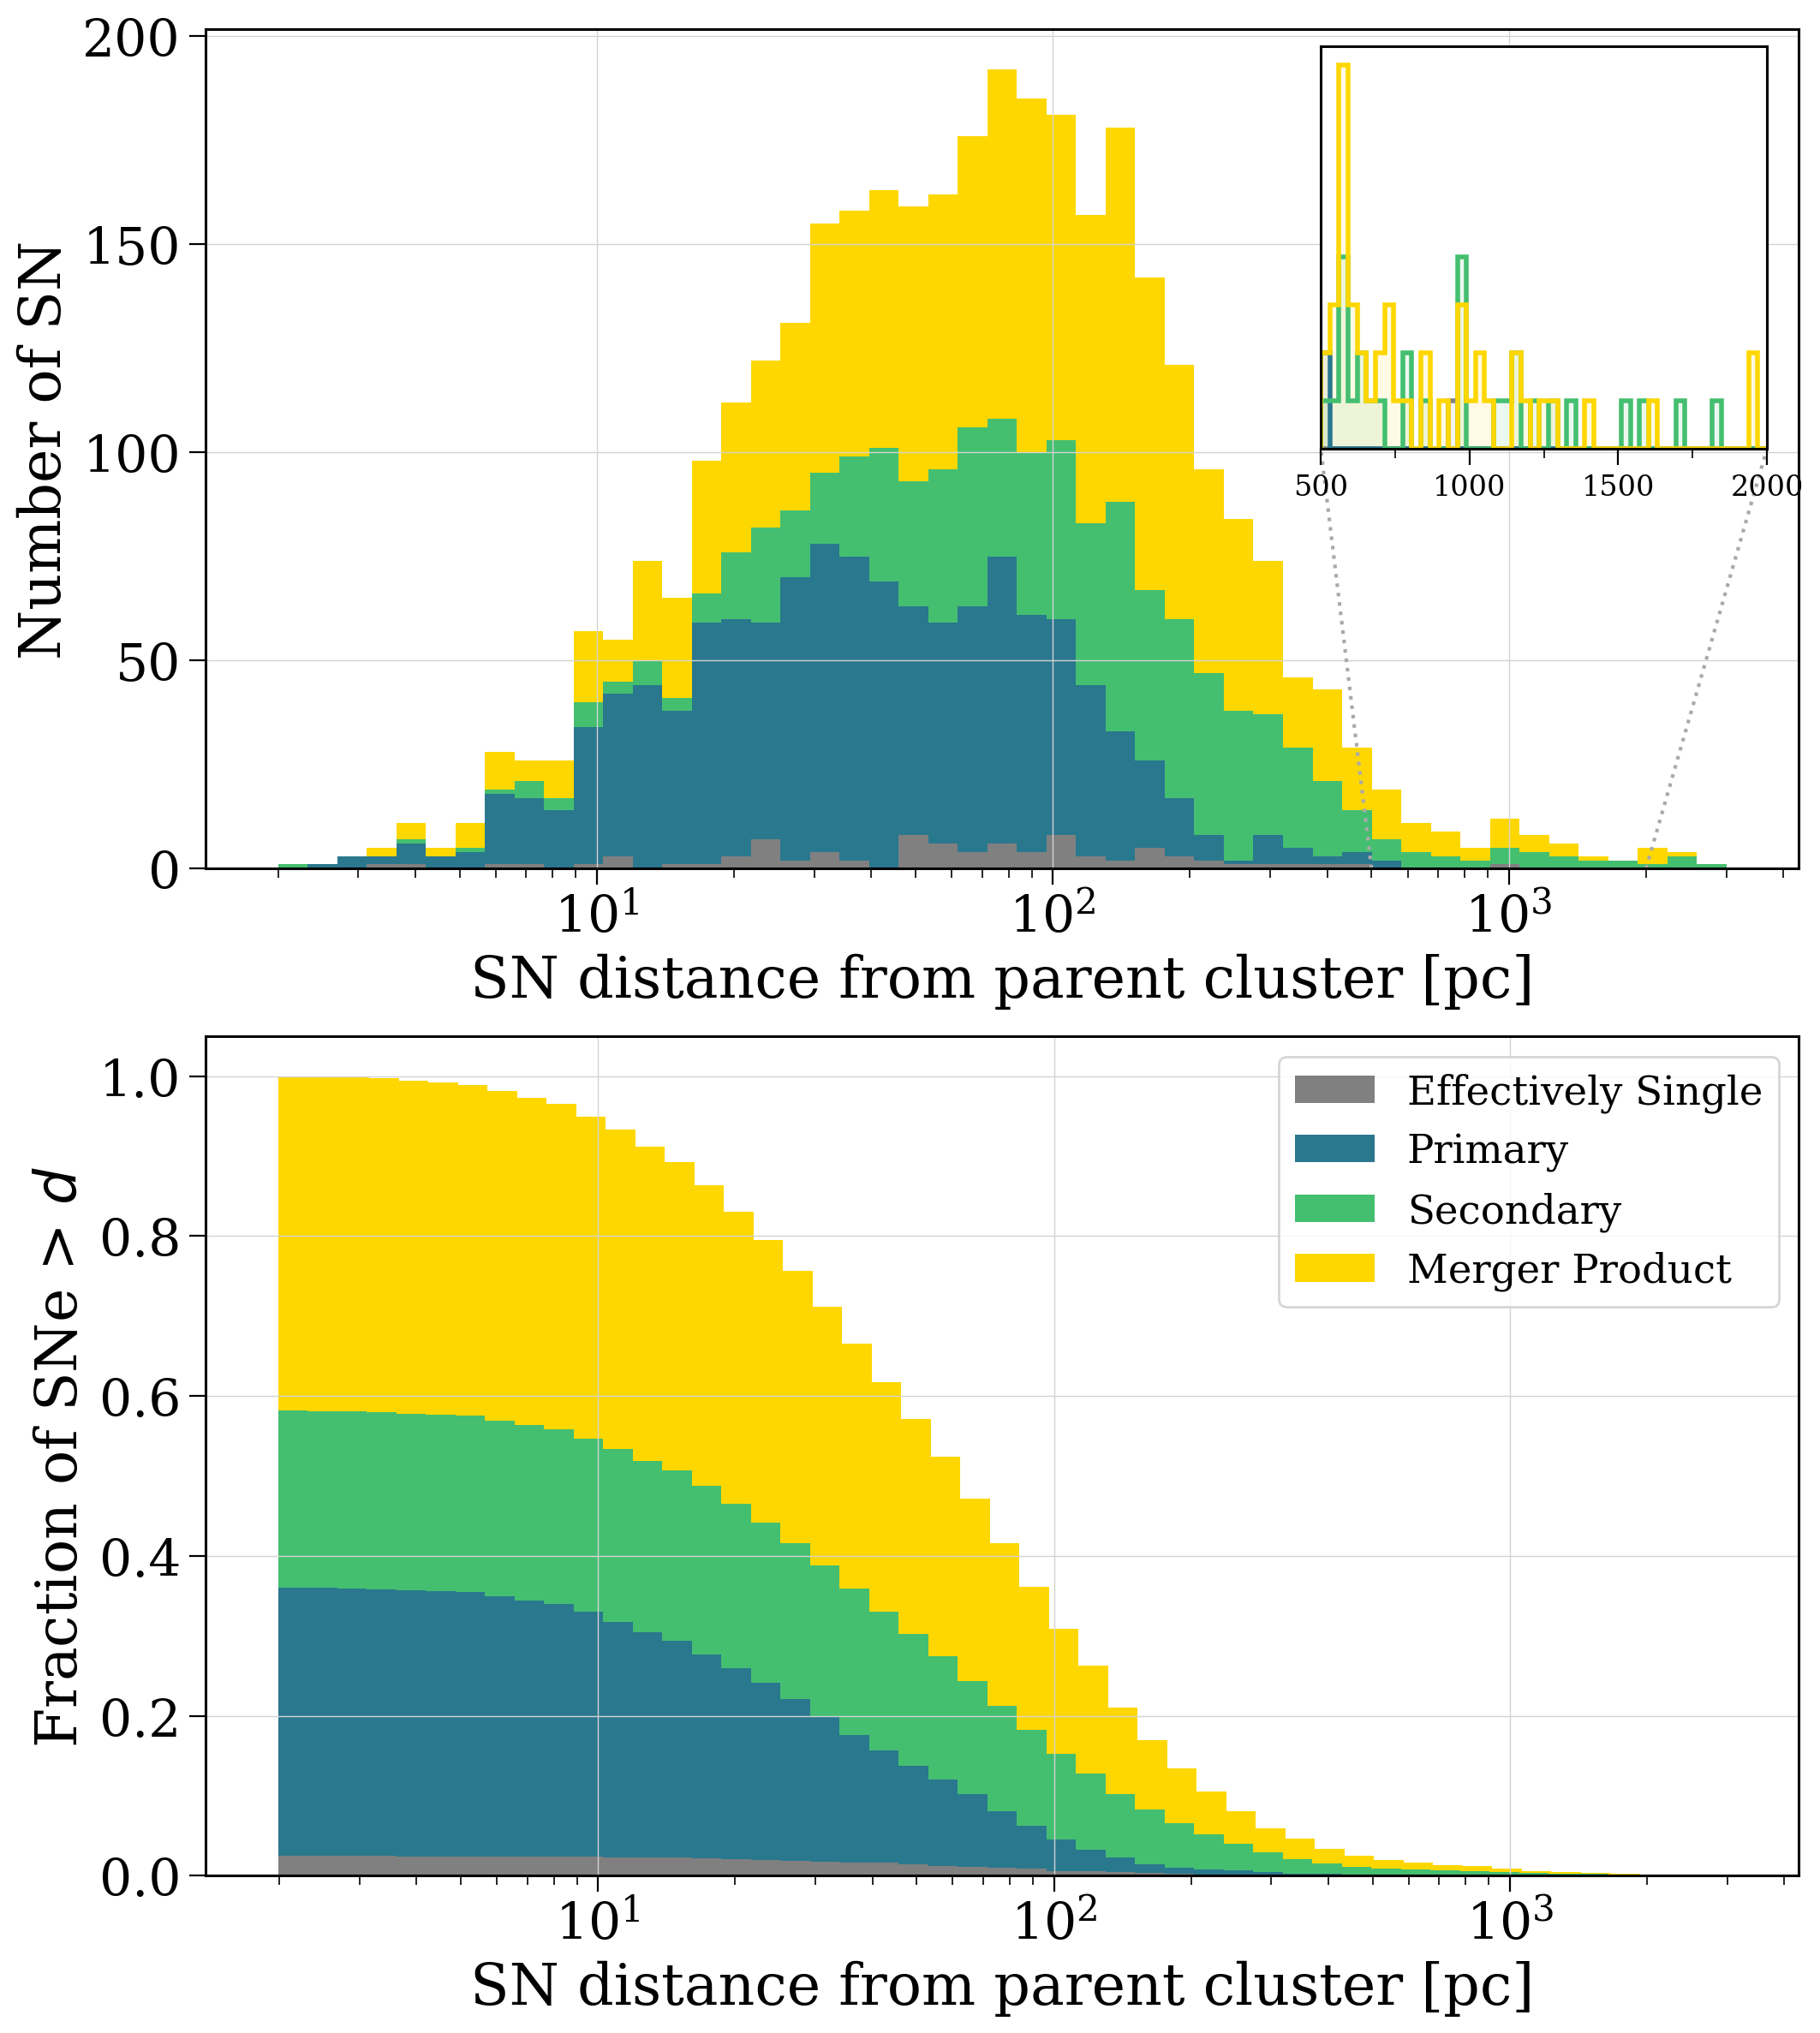

In [204]:
reload(plotting)
fig, ax = plotting.sn_distance_histograms(p, bins=np.geomspace(2e0, 3e3, 50))

0.03004029970864721
0.25317328683724405
0.21902086427627465
0.4977655491778341


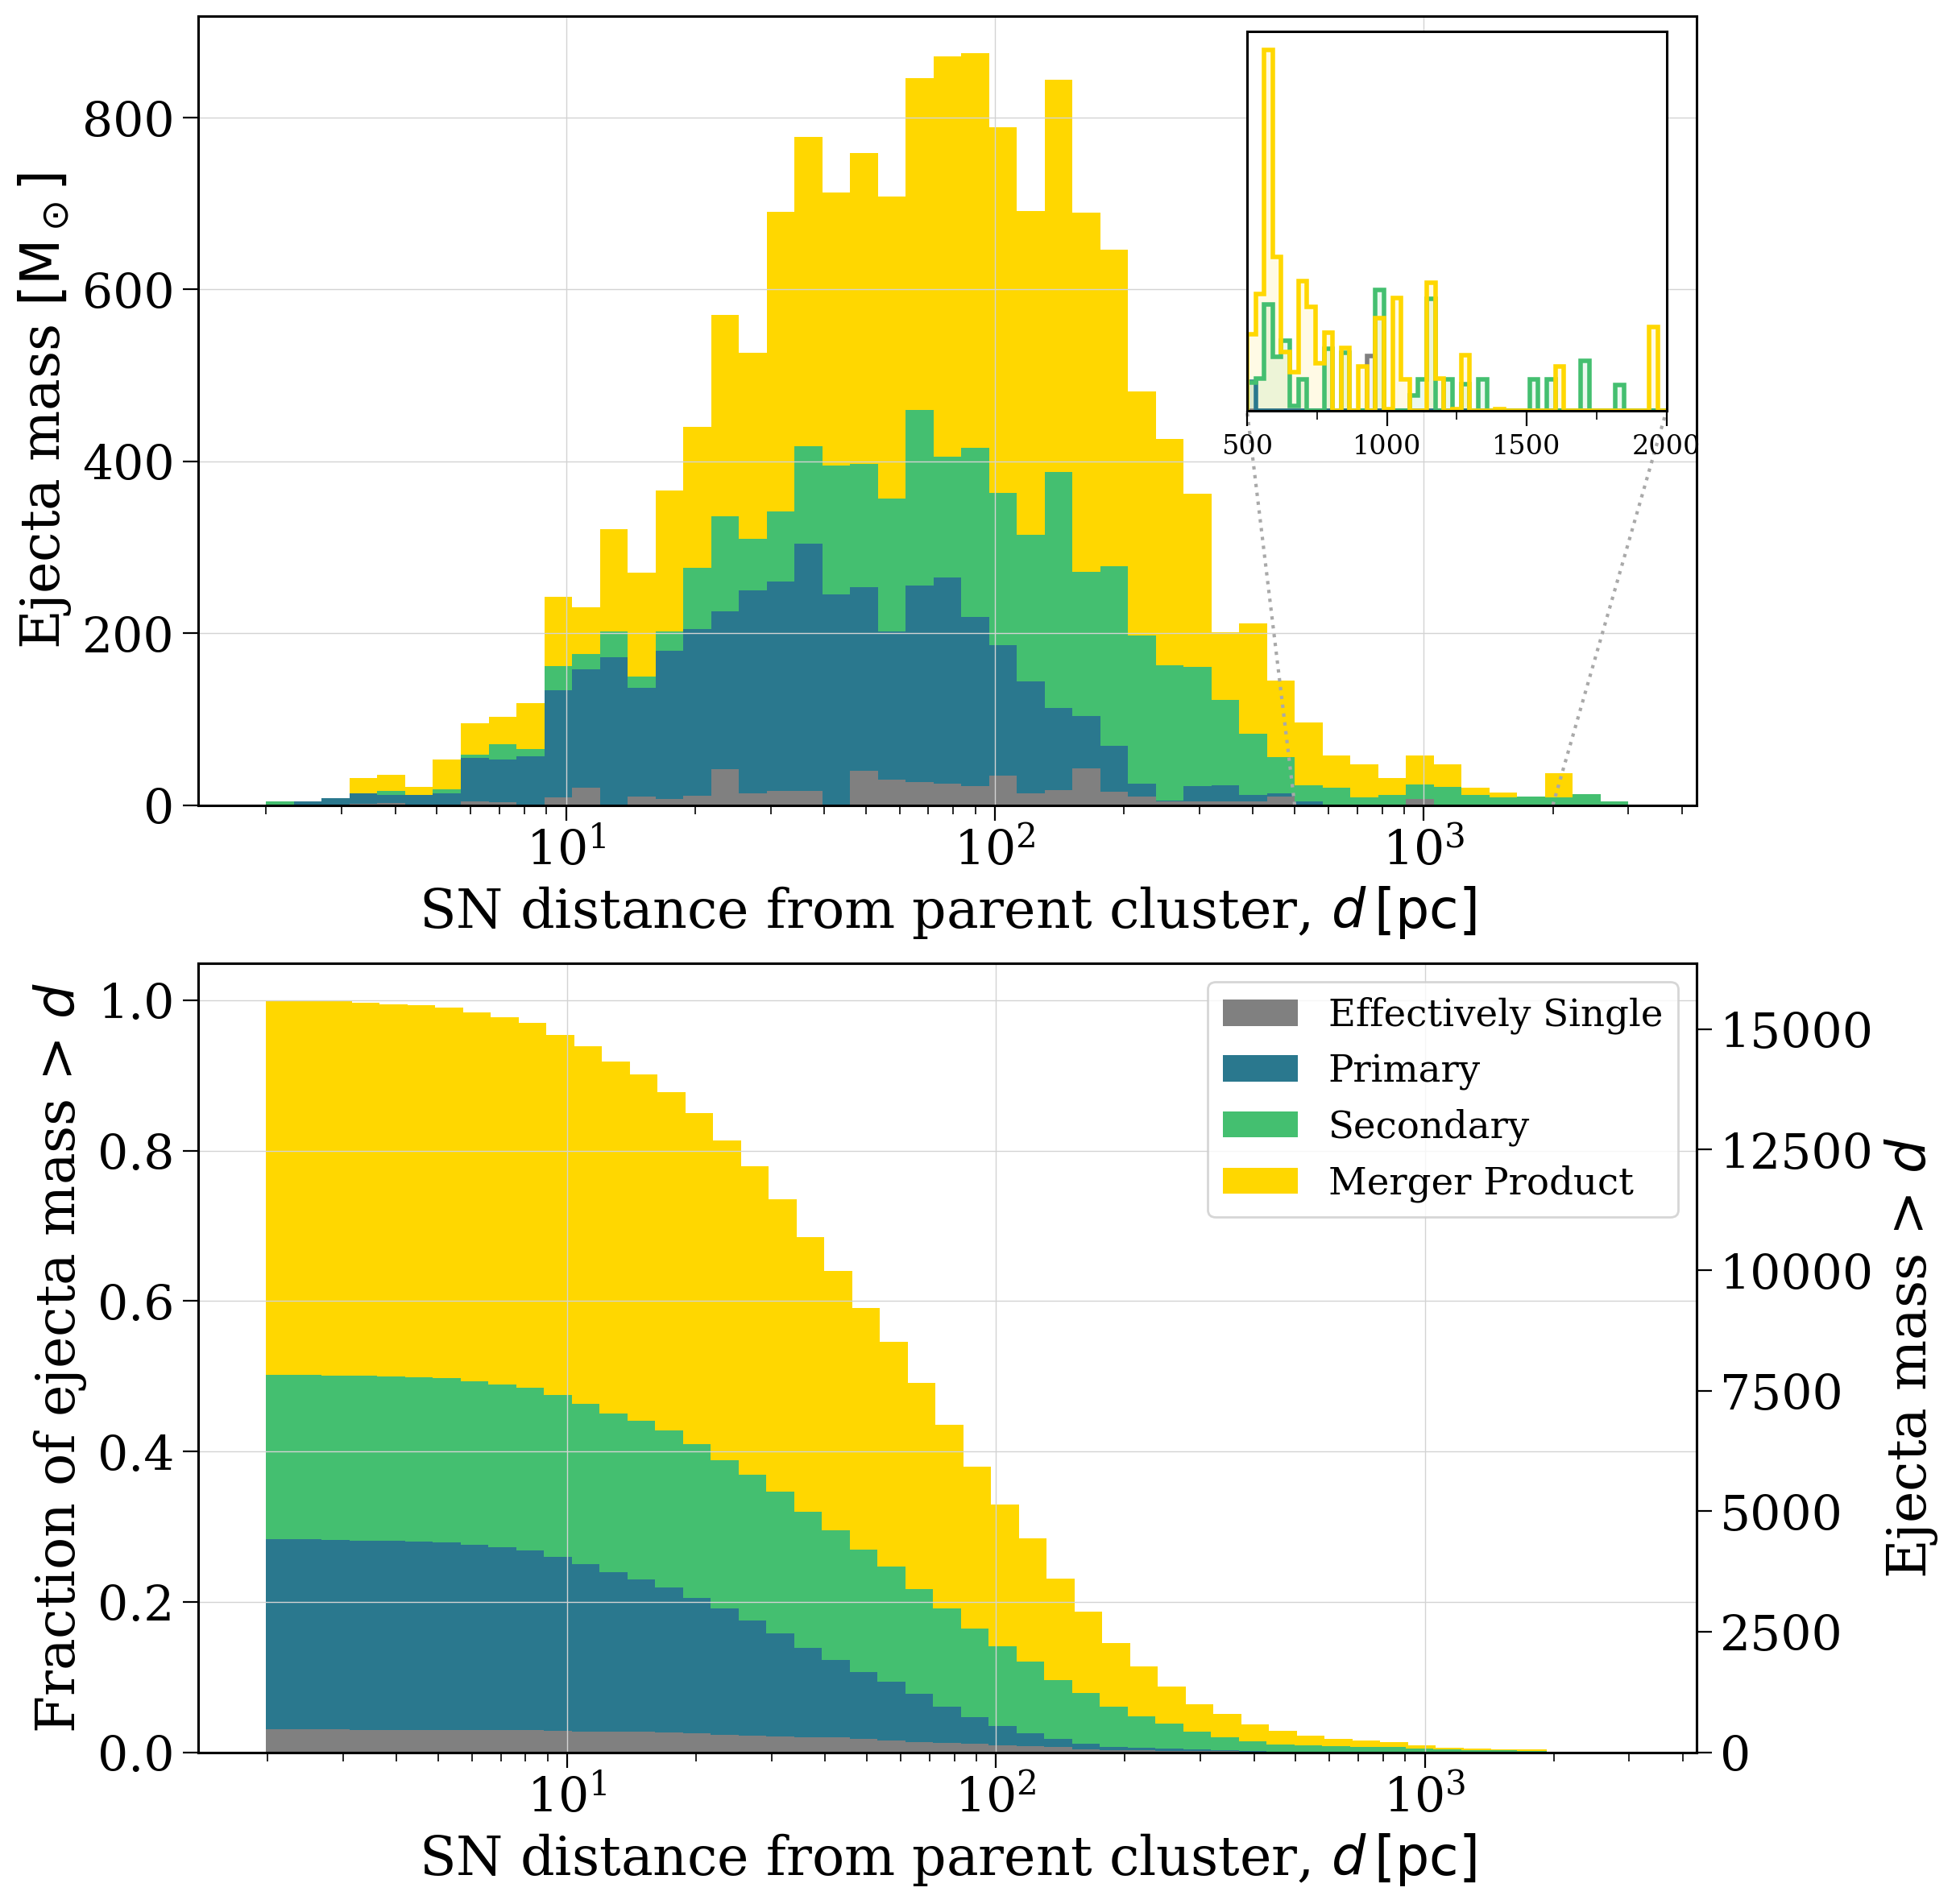

In [235]:
reload(plotting)
fig, ax = plotting.ejecta_mass_distance_histograms(p, bins=np.geomspace(2e0, 3e3, 50))